# Predicting Magnetic Field Values for Satellites

Author: Simon Lachaîne
simonthechain@gmail.com

## Objective

Analyze the altitude from Earth as recorded by a satellite to determine if that parameter can be used to predict the magnetic field experienced by the satellite.

## Dataset

MOST-268_HD209458_2014-268_HD209458_2014: A .tar file containing .fits files compressed as .tar files.

This dataset is available online: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/?collection=MOST&noexec=true#resultTableTab

The data was recorded by the MOST satellite: http://www.asc-csa.gc.ca/fra/satellites/most/default.asp

## Initialization

In [1]:
import os
import tarfile

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from astropy.visualization import astropy_mpl_style
from astropy.io import fits

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use(astropy_mpl_style)
%matplotlib inline

In [3]:
def distribution_plot(red_function, blue_function, red_name, blue_name, title):
    """
    Creates a distribution plot
    parameter red_function: predictor values
    parameter blue_function: target values
    parameter red_name: label for red function
    parameter blue_name: label for blue function
    parameter title: title of the graph
    return: None
    """
    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(14, 8))

    plt.title(title)

    ax1 = sns.distplot(
        red_function,
        hist=False,
        color="r",
        label=red_name
    )
    sns.distplot(
        blue_function,
        hist=False,
        color="b",
        label=blue_name,
        ax=ax1
    )
    sns.despine()

## Loading Data

In [4]:
# locate the dataset directory relative to this notebook
notebook_path = os.path.abspath("predict_magnetic_field.ipynb")
tar_dir = os.path.join(os.path.dirname(os.path.dirname(notebook_path)), "datasets/")

In [5]:
data = []

for root, dirs, files in os.walk(tar_dir):
    for f in files:
        if os.path.splitext(f)[1] == ".tar":
            
            # extract .tar file in memory
            with tarfile.open(
                name=os.path.join(root, f),
                mode="r"
            ) as tar_obj:
                
                # for every file in the tar file
                for member in tar_obj.getnames():
                    if os.path.splitext(member)[1] == ".fits":
                        extracted = tar_obj.extractfile(member)
                        
                        # open extracted .fits file
                        with fits.open(extracted) as hdul:
                            hdr = hdul[0].header
                            
                            data_dct = {
                                "exposure_date": hdr["DATE-OBS"],
                                "magnetic_field": hdr["MAG_FLD"],
                                "altitude": hdr["SAT_ALT"],
                            }
                            data.append(data_dct)

In [28]:
# create a dataframe from the list of data dictionaries
print(data_dct)

{'exposure_date': '2014-08-28T11:13:05.000', 'magnetic_field': 39671.557, 'altitude': 809688.375}


## Data Preprocessing

In [7]:
# use readable column names
display_names = {
    "exposure_date": "Exposure Date",
    "altitude": "Altitude",
    "magnetic_field": "Magnetic Field",
}
df.rename(columns=display_names, inplace=True)

In [8]:
# set exposure date as index
df["Exposure Date"] = pd.to_datetime(df["Exposure Date"], format="%Y-%m-%dT%H:%M:%S.000")
df.set_index(keys="Exposure Date", inplace=True)
df.sort_index(axis=0, ascending=True, inplace=True)

In [9]:
# sanity check
df.head()

Altitude  Magnetic Field
Exposure Date                                  
2014-08-19 20:11:35  838931.497       22098.867
2014-08-19 20:12:37  838699.525       21012.742
2014-08-19 20:13:39  838418.956       20113.562
2014-08-19 20:14:41  838088.724       19390.773
2014-08-19 21:19:35  825348.484       27947.868

## Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6708 entries, 2014-08-19 20:11:35 to 2014-09-10 01:30:28
Data columns (total 2 columns):
Altitude          6708 non-null float64
Magnetic Field    6708 non-null float64
dtypes: float64(2)
memory usage: 157.2 KB


In [11]:
df.describe()

Altitude  Magnetic Field
count    6708.000000     6708.000000
mean   819475.459218    33183.963045
std      9643.641820     7281.736133
min    808725.743000    17019.006000
25%    810733.799250    26888.738000
50%    816228.227000    34994.234500
75%    827720.180250    39993.574750
max    839441.271000    44679.224000

## Line Plot

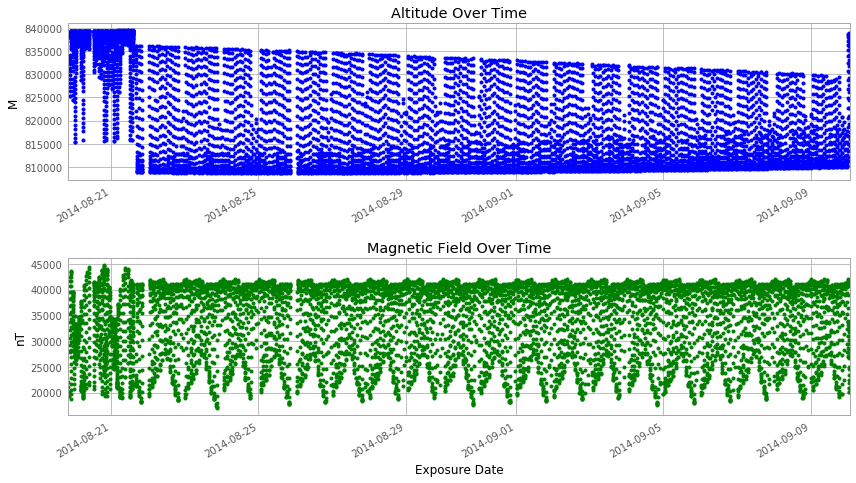

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

df["Altitude"].plot(kind="line", color="b", style=".", ax=ax1, legend=False)
ax1.xaxis.set_label_text("")
ax1.yaxis.set_label_text("M")
ax1.set_title("Altitude Over Time")

df["Magnetic Field"].plot(kind="line", color="g", style=".", ax=ax2)
ax2.yaxis.set_label_text("nT")
ax2.set_title("Magnetic Field Over Time")
fig.subplots_adjust(hspace=0.5)

plt.show()

The line plot gives us an eagle eye's view of the data.  We can see at first glance that there seems to be a relationship between the altitude of the satellite and the magnetic field.

## Box Plot

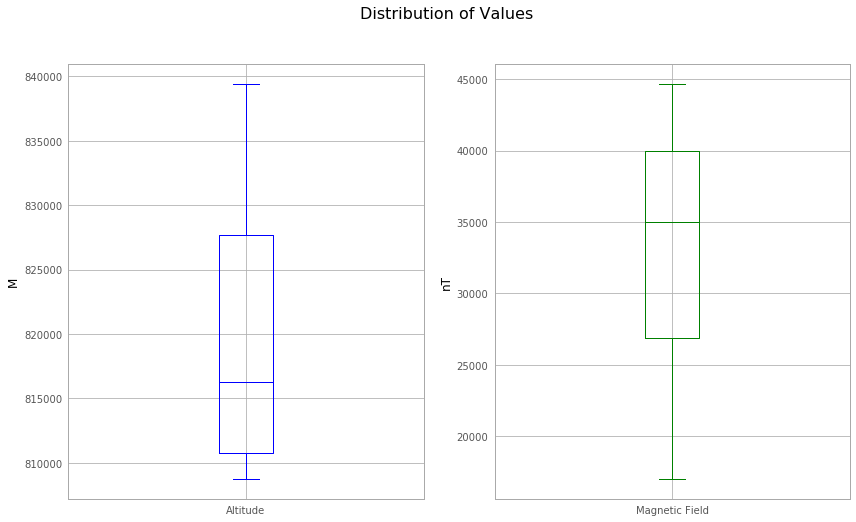

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

df["Altitude"].plot(kind="box", color="b", ax=ax1)
ax1.yaxis.set_label_text("M")

df["Magnetic Field"].plot(kind="box", color="g", ax=ax2)
ax2.yaxis.set_label_text("nT")
fig.suptitle("Distribution of Values", fontsize=16)

plt.show()

These box plots show values that are mostly homogeneous, without any outliers.

## Regression Plot

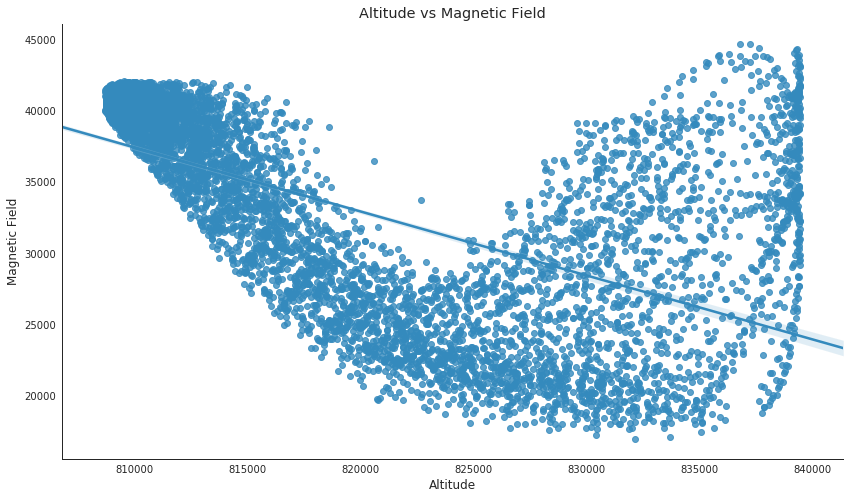

In [14]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 8))

plt.title("Altitude vs Magnetic Field")
sns.regplot(
    x="Altitude",
    y="Magnetic Field",
    data=df,
    ax=ax
)
sns.despine()

The fitted line represents the predicted value; its diagonal suggest that there is a certain relationship between the two features.  We can see that the actual data points are close to the line at low altitudes, but then drift downwards then up in a larger pattern as the altitude increases.

## Pearson Correlation

In [15]:
"""
Correlation coefficient:
Close to +1: Large positive relationship
Close to -1: Large negative relationship
Close to 0: No relationship

P-value:
< 0.001: Strong certainty in the results
< 0.05: Moderate certainty in the results
< 0.1: Weak certainty in the results
> 0.1: No certainty in the results
"""
pearson_coef, p_value = stats.pearsonr(df["Altitude"], df["Magnetic Field"])
print("Coefficient: {}\nP-Value: {}".format(pearson_coef, p_value))

Coefficient: -0.5941582377514554
P-Value: 0.0


The value of the coefficient indicates that there is a moderate to strong relationship between the two features, and the p-value represents a very high certainty of this interpretation.

## Residual Plot

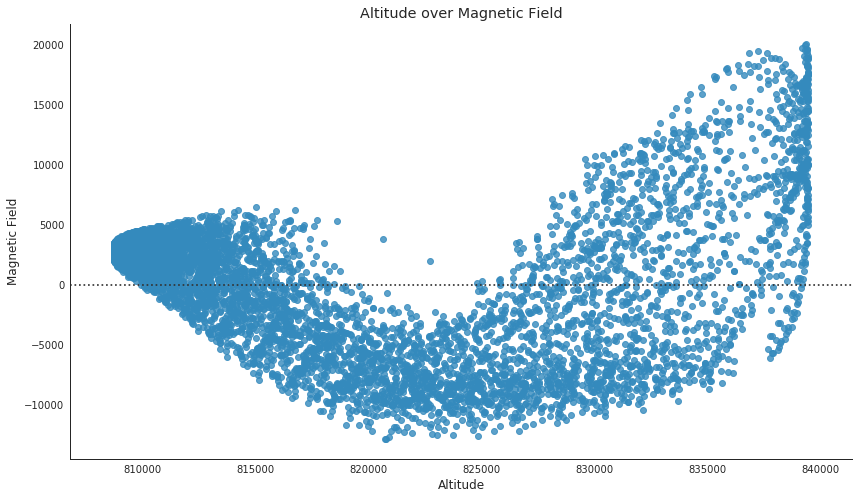

In [16]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 8))

plt.title("Altitude over Magnetic Field")
sns.residplot(
    x="Altitude",
    y="Magnetic Field",
    data=df,
    ax=ax
)
sns.despine()

Here the values of the error change with the altitude; the residuals are not randomly seperated.  This suggests the linear assumption is incorrect; however we can apply a polynomial transformation to make the model more flexible.

## Training and Testing

In [17]:
# split the predictor and target values into two dataframes
y_data = df["Magnetic Field"]
x_data = df.drop("Magnetic Field", axis=1)

In [18]:
# randomly split data into training and testing groups
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)

print("Number of training samples: {}".format(x_train.shape[0]))
print("Number of test samples: {}".format(x_test.shape[0]))

Number of training samples: 5701
Number of test samples: 1007


## Linear Regression

In [19]:
lre = LinearRegression()
lre.fit(x_train[["Altitude"]], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
# calculate R^2 on the test data
lre.score(x_test[["Altitude"]], y_test)

0.37187530793198975

In [21]:
# calculate R^2 on the training data
lre.score(x_train[["Altitude"]], y_train)

0.349569520855216

## Cross-Validation Score

In [22]:
r_cross = cross_val_score(lre, x_data[["Altitude"]], y_data, cv=4)
print("Cross-validation score using R^2: {}".format(r_cross))

Cross-validation score using R^2: [-1.00600776  0.52752917  0.47019131  0.39082977]


In [23]:
print("Mean of the folds: {}\nStandard deviation: {}".format(r_cross.mean(), r_cross.std()))

Mean of the folds: 0.09563562136063354
Standard deviation: 0.6378835539964456


In [24]:
# predicting the output
yhat = cross_val_predict(lre, x_data[["Altitude"]], y_data, cv=4)

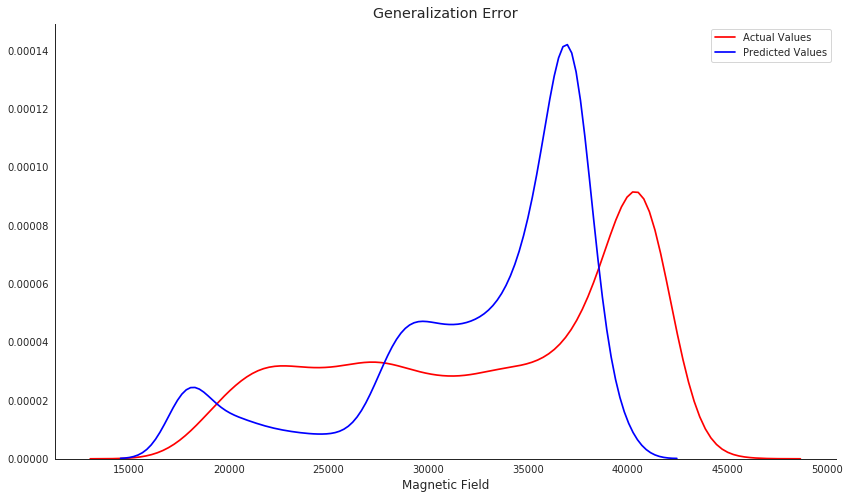

In [25]:
distribution_plot(df["Magnetic Field"], yhat, "Actual Values", "Predicted Values", "Generalization Error")

## Normalization, Polynomial Features and Linear Regression

In [26]:
# predictor feature
x = df[["Altitude"]]

# target feature
y = df["Magnetic Field"]

pipeline_input = [
    ("scale", StandardScaler()),
    ("polynomial", PolynomialFeatures(degree=4)),
    ("model", LinearRegression())
]

pipe = Pipeline(pipeline_input)
pipe.fit(x, y)
yhat = pipe.predict(x)

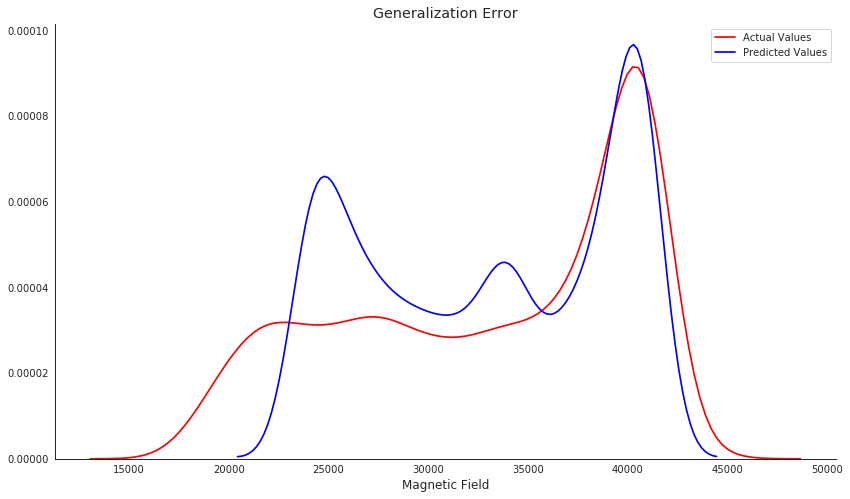

In [27]:
distribution_plot(df["Magnetic Field"], yhat, "Actual Values", "Predicted Values", "Generalization Error")

## Conclusion

The regression plot and Pearson correlation seem to indicate that there is indeed a relationship between the altitude of the satellite and the intensity of the magnetic field it experiences.

However, the distribution plot displays some significant differences from the actual values, especially when the magnetic field is less intense.

A possible explanation for this is that the closer the satellite is to Earth, the more it is envelopped by its magnetosphere, and thus other factors, such as charged particles present in the solar wind, become less significant.